# Temperature prediction with RNN
https://www.kaggle.com/datasets/mnassrib/jena-climate

In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib.pyplot as plt

Dataset preparation

In [2]:
import os
with open('jena_climate_2009_2016.csv') as file:
    data = file.read()

In [3]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

In [4]:
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    temp = [float(x) for x in line.split(',')[1:]]
    temperature[i] = temp[1]
    raw_data[i,:] = temp[:]

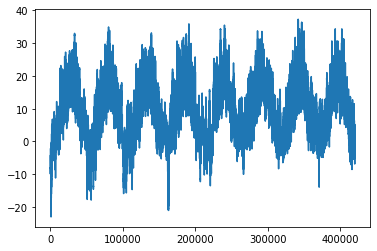

In [5]:
plt.plot(range(len(temperature)), temperature)

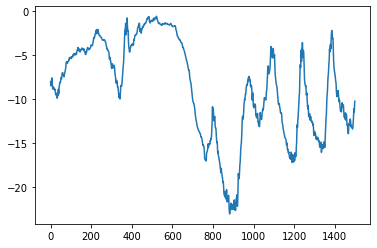

In [6]:
plt.plot(range(1500), temperature[:1500])

In [7]:
n_train = int(0.5*len(lines))
n_val = int(0.25*len(lines))
n_test = len(lines) - n_train -n_val
n_train, n_val, len(lines), n_test+ n_val+n_train

(210225, 105112, 420451, 420451)

Normalizing

In [8]:
mean = raw_data[:n_train].mean(axis=0)
std = raw_data[:n_train].std(axis=0)
raw_data = (raw_data-mean) / std

Dataset creating

In [9]:
sampling_rate = 6 #Observations will be sampled at one data point per hour: we will only keep one data point out of 6.
sequence_length = 120 #Observations will go back 5 days (120 hours).
delay = sampling_rate * (sequence_length + 24 - 1) #The target for a sequence will be the temperature 24 hours after the end of the sequence
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=n_train
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=n_train,
    end_index=n_train + n_val
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    data=raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=n_train + n_val,
    )

In [12]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 14)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, 16)                1984      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 2,001
Trainable params: 2,001
Non-trainable params: 0
_________________________________________________________________


In [13]:
callbacks = [keras.callbacks.ModelCheckpoint("jena_conv.keras",save_best_only=True)]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 41s 49ms/step - loss: 45.3961 - mae: 4.9269 - val_loss: 13.3779 - val_mae: 2.7600
Epoch 2/10
819/819 [==============================] - 42s 51ms/step - loss: 11.1370 - mae: 2.5896 - val_loss: 9.3982 - val_mae: 2.3781
Epoch 3/10
819/819 [==============================] - 41s 50ms/step - loss: 9.7845 - mae: 2.4435 - val_loss: 9.5216 - val_mae: 2.3973
Epoch 4/10
819/819 [==============================] - 38s 47ms/step - loss: 9.3890 - mae: 2.3943 - val_loss: 9.4673 - val_mae: 2.3847
Epoch 5/10
819/819 [==============================] - 39s 48ms/step - loss: 9.1410 - mae: 2.3591 - val_loss: 9.5120 - val_mae: 2.3923
Epoch 6/10
819/819 [==============================] - 39s 48ms/step - loss: 8.9350 - mae: 2.3298 - val_loss: 9.4163 - val_mae: 2.3800
Epoch 7/10
819/819 [==============================] - 41s 50ms/step - loss: 8.7283 - mae: 2.2992 - val_loss: 9.5607 - val_mae: 2.3974
Epoch 8/10
819/819 [==============================] - 41s 5

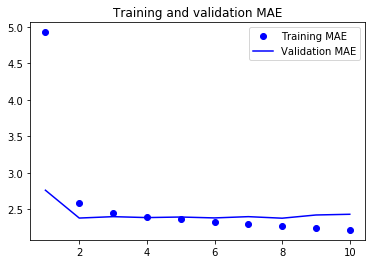

In [14]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()

Adding Dropout

In [15]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)
callbacks = [keras.callbacks.ModelCheckpoint('jena_lstm_dropout.keras', save_best_only=True)]

model.compile(
    optimizer='rmsprop',
    loss='mse',
    metrics='mae'
)

In [16]:
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/50
819/819 [==============================] - 88s 106ms/step - loss: 27.2458 - mae: 3.8588 - val_loss: 9.5731 - val_mae: 2.4064
Epoch 2/50
819/819 [==============================] - 90s 110ms/step - loss: 14.7468 - mae: 2.9807 - val_loss: 9.2811 - val_mae: 2.3737
Epoch 3/50
819/819 [==============================] - 92s 112ms/step - loss: 14.0269 - mae: 2.9027 - val_loss: 9.3127 - val_mae: 2.3833
Epoch 4/50
819/819 [==============================] - 92s 112ms/step - loss: 13.2528 - mae: 2.8206 - val_loss: 9.4281 - val_mae: 2.4035
Epoch 5/50
819/819 [==============================] - 89s 109ms/step - loss: 12.7518 - mae: 2.7682 - val_loss: 9.3013 - val_mae: 2.3804
Epoch 6/50
819/819 [==============================] - 84s 102ms/step - loss: 12.3763 - mae: 2.7304 - val_loss: 9.4515 - val_mae: 2.4042
Epoch 7/50
819/819 [==============================] - 94s 114ms/step - loss: 12.1163 - mae: 2.7005 - val_loss: 9.5101 - val_mae: 2.4051
Epoch 8/50
819/819 [============================

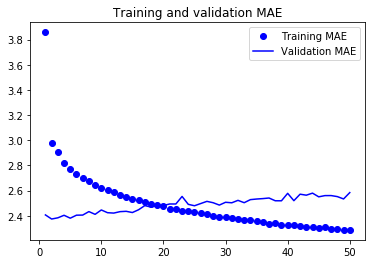

In [17]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()

Stacking layers

In [10]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
            keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
            save_best_only=True)
            ]

In [11]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 161s 193ms/step - loss: 22.0908 - mae: 3.5109 - val_loss: 9.4690 - val_mae: 2.3954
Epoch 2/50
819/819 [==============================] - 154s 189ms/step - loss: 14.1131 - mae: 2.9121 - val_loss: 9.8293 - val_mae: 2.4476
Epoch 3/50
819/819 [==============================] - 152s 185ms/step - loss: 13.3991 - mae: 2.8332 - val_loss: 8.6546 - val_mae: 2.2682
Epoch 4/50
819/819 [==============================] - 155s 189ms/step - loss: 12.8393 - mae: 2.7758 - val_loss: 8.8176 - val_mae: 2.3056
Epoch 5/50
819/819 [==============================] - 193s 235ms/step - loss: 12.2556 - mae: 2.7140 - val_loss: 8.6510 - val_mae: 2.2793
Epoch 6/50
819/819 [==============================] - 171s 208ms/step - loss: 11.8031 - mae: 2.6672 - val_loss: 8.6808 - val_mae: 2.2811
Epoch 7/50
819/819 [==============================] - 150s 183ms/step - loss: 11.4285 - mae: 2.6226 - val_loss: 9.8663 - val_mae: 2.4536
Epoch 8/50
819/819 [=====================

Bidirectional RNN

In [12]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 66s 77ms/step - loss: 24.9116 - mae: 3.5867 - val_loss: 11.2485 - val_mae: 2.6132
Epoch 2/10
819/819 [==============================] - 63s 76ms/step - loss: 9.1933 - mae: 2.3670 - val_loss: 10.2606 - val_mae: 2.5056
Epoch 3/10
819/819 [==============================] - 62s 76ms/step - loss: 8.1943 - mae: 2.2326 - val_loss: 10.3477 - val_mae: 2.5213
Epoch 4/10
819/819 [==============================] - 63s 77ms/step - loss: 7.5611 - mae: 2.1438 - val_loss: 10.4801 - val_mae: 2.5248
Epoch 5/10
819/819 [==============================] - 63s 77ms/step - loss: 7.1196 - mae: 2.0805 - val_loss: 11.3632 - val_mae: 2.6168
Epoch 6/10
819/819 [==============================] - 63s 77ms/step - loss: 6.7614 - mae: 2.0270 - val_loss: 10.5030 - val_mae: 2.5231
Epoch 7/10
819/819 [==============================] - 62s 76ms/step - loss: 6.4787 - mae: 1.9839 - val_loss: 11.1857 - val_mae: 2.5966
Epoch 8/10
819/819 [==============================] - 

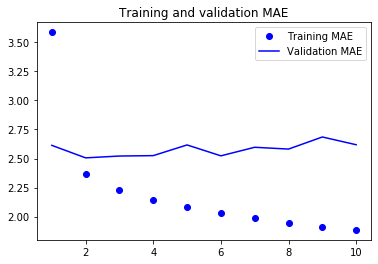

In [13]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()